In [1]:
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from Image_Functions import slicing, crop_images_to_brain, crop_to_size
from datasetModule import Set
from torch import nn

Most of the functionallity is stored in module files. 
The data consist of Images with 3 channels and segmentation images with 2 channels.


In [2]:
"Need to specify the local path on computer"
dir_path = "../Task3/"

In [3]:
'Splitting the data into 30% test and 70% training.'
X_train, X_test = train_test_split(Set(dir_path, sub_dir = 'sub-23'), test_size=0.3, random_state=25)

../Task3/sub-233
../Task3/sub-232
../Task3/sub-234
../Task3/sub-230
../Task3/sub-231


In [4]:
X_train, X_test = crop_images_to_brain(X_train), crop_images_to_brain(X_test)
size = (256,288,176)
#size = (128,128,128)
X_train_c, X_test_c = crop_to_size(X_train, size), crop_to_size(X_test,size)

3
torch.Size([3, 275, 330, 168])
torch.Size([3, 275, 330, 168])
torch.Size([3, 275, 330, 168])
2
torch.Size([3, 281, 340, 182])
torch.Size([3, 281, 340, 182])
torch.Size([3, 256, 288, 176])
torch.Size([2, 256, 288, 176])
torch.Size([3, 256, 288, 176])
torch.Size([2, 256, 288, 176])
torch.Size([3, 256, 288, 176])
torch.Size([2, 256, 288, 176])
torch.Size([3, 256, 288, 176])
torch.Size([2, 256, 288, 176])
torch.Size([3, 256, 288, 176])
torch.Size([2, 256, 288, 176])


In [ ]:
'Visualising slices of images along all three axis'
for i in range(len(X_train_c)):
    for j in range(3):
        img = X_train_c[i]['data'][j]
        img = img.float()
        slicing(img)

In order to access the set after they have been parsed through the dataloader:


To access a batch: batch = next(iter(<<Insert name here>>))


To access the data: batch['batchnumber']['data']


To access the segmentation: batch['batchnumber']['seg]

In [9]:
'Load training and test set, batch size may vary'
train_set, test_set = DataLoader(X_train_c, batch_size=1), DataLoader(X_test_c, batch_size=1)

In [10]:
tmp = next(iter(train_set))
image = tmp['data']
print(image.shape)



torch.Size([1, 3, 256, 288, 176])


In [11]:
import torch
from torch import nn
from torch.nn import parameter
import Model

In [16]:
'Run the CNN'
model = Model.CNN(3, None)
print(model)


CNN(
  (conv1_layer1): Sequential(
    (0): Conv3d(3, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): LeakyReLU(negative_slope=0.01)
  )
  (conv1_layer2): Sequential(
    (0): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): LeakyReLU(negative_slope=0.01)
  )
  (maxPool1): MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2_layer1): Sequential(
    (0): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): LeakyReLU(negative_slope=0.01)
  )
  (conv2_layer2): Sequential(
    (0): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): LeakyReLU(negative_slope=0.01)
  )
  (maxPool2): MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv3_layer1): Sequential(
    (0): Conv3d(128, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): LeakyReLU(negative_slope=0.0

In [17]:
out_img = model(image)


Layer 1: torch.Size([1, 32, 256, 288, 176])
torch.Size([1, 32, 128, 144, 88])
Layer 2: torch.Size([1, 128, 128, 144, 88])
Layer 3: torch.Size([1, 256, 64, 72, 44])
Layer 4: torch.Size([1, 512, 32, 36, 22])
Layer 5: torch.Size([1, 256, 64, 72, 44])
Layer 6: torch.Size([1, 128, 128, 144, 88])
Layer 7: torch.Size([1, 16, 256, 288, 176])


torch.Size([256, 288, 176])


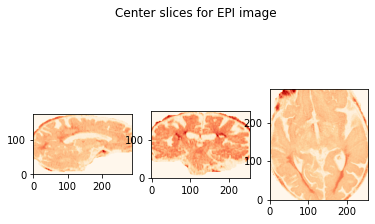

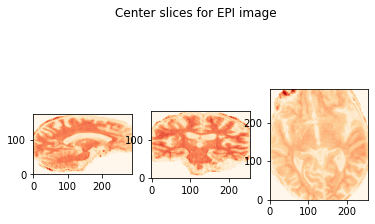

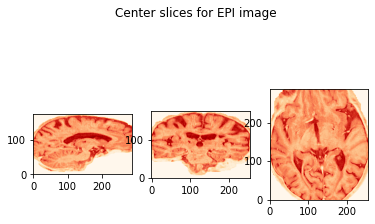

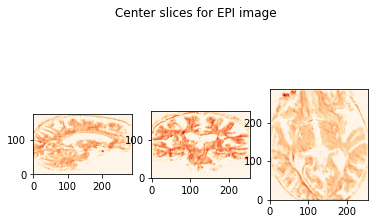

In [27]:

print(out_img[0][0].shape)
img = out_img[0][0]
img = img.detach().numpy()
for imgur in image[0]:
    slicing(imgur)
slicing(img)